In [1]:

# NutriGreen Dataset - Exploratory Data Analysis and Preparation
# Run this notebook first to understand your data and prepare it for training

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
from collections import Counter
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 1. SETUP PATHS
# ============================================================================
print("=" * 80)
print("NUTRIGREEN DATASET - EDA AND PREPARATION")
print("=" * 80)

BASE_DIR = Path(r"C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset")
IMAGES_DIR = BASE_DIR / "images"
LABELS_DIR = BASE_DIR / "labels"
CSV_FILE = BASE_DIR / "data.csv"
UNLABELED_DIR = BASE_DIR / "unlabeled_data"

# Create YOLOv5 directory structure
YOLO_DIR = BASE_DIR / "yolov5_data"
YOLO_DIR.mkdir(exist_ok=True)

for split in ['train', 'val', 'test']:
    (YOLO_DIR / split / 'images').mkdir(parents=True, exist_ok=True)
    (YOLO_DIR / split / 'labels').mkdir(parents=True, exist_ok=True)

print(f"\n✓ Directories created at: {YOLO_DIR}")

NUTRIGREEN DATASET - EDA AND PREPARATION

✓ Directories created at: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data


In [3]:
# ============================================================================
# 2. LOAD AND EXPLORE DATA
# ============================================================================
print("\n" + "=" * 80)
print("LOADING DATA")
print("=" * 80)

df = pd.read_csv(CSV_FILE)
print(f"\n✓ Loaded {len(df)} annotations from CSV")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Basic statistics
print("\n" + "=" * 80)
print("DATASET STATISTICS")
print("=" * 80)

print(f"\nTotal annotations: {len(df)}")
print(f"Unique images: {df['File Name'].nunique()}")
print(f"Average annotations per image: {len(df) / df['File Name'].nunique():.2f}")


LOADING DATA

✓ Loaded 8509 annotations from CSV

Dataset shape: (8509, 6)

Column names: ['File Name', 'Class ID', 'X', 'Y', 'Width', 'Height']

First few rows:
               File Name  Class ID         X         Y     Width    Height
0  nutriScoreD (657).txt         3  0.365901  0.847100  0.135998  0.223199
1  nutriScoreE (535).txt         4  0.149490  0.899385  0.246464  0.125659
2      3256226080853.txt         5  0.636986  0.850000  0.107632  0.050000
3  nutriScoreD (207).txt         3  0.311250  0.733940  0.111667  0.150964
4   nutriScoreB (98).txt         1  0.853403  0.830666  0.191099  0.067397

DATASET STATISTICS

Total annotations: 8509
Unique images: 7271
Average annotations per image: 1.17


In [4]:
# ============================================================================
# 3. CLASS DISTRIBUTION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("CLASS DISTRIBUTION")
print("=" * 80)

class_names = {
    0: 'NutriScore A',
    1: 'NutriScore B',
    2: 'NutriScore C',
    3: 'NutriScore D',
    4: 'NutriScore E',
    5: 'BIO',
    6: 'V-Label'
}

df['Class Name'] = df['Class ID'].map(class_names)
class_counts = df['Class ID'].value_counts().sort_index()

print("\nClass distribution:")
for class_id, count in class_counts.items():
    print(f"  {class_names[class_id]:<15} (ID: {class_id}): {count:>5} samples ({count/len(df)*100:.1f}%)")


CLASS DISTRIBUTION

Class distribution:
  NutriScore A    (ID: 0):  1274 samples (15.0%)
  NutriScore B    (ID: 1):  1114 samples (13.1%)
  NutriScore C    (ID: 2):   872 samples (10.2%)
  NutriScore D    (ID: 3):  1007 samples (11.8%)
  NutriScore E    (ID: 4):   973 samples (11.4%)
  BIO             (ID: 5):  2394 samples (28.1%)
  V-Label         (ID: 6):   875 samples (10.3%)



✓ Class distribution plot saved to: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data\class_distribution.png


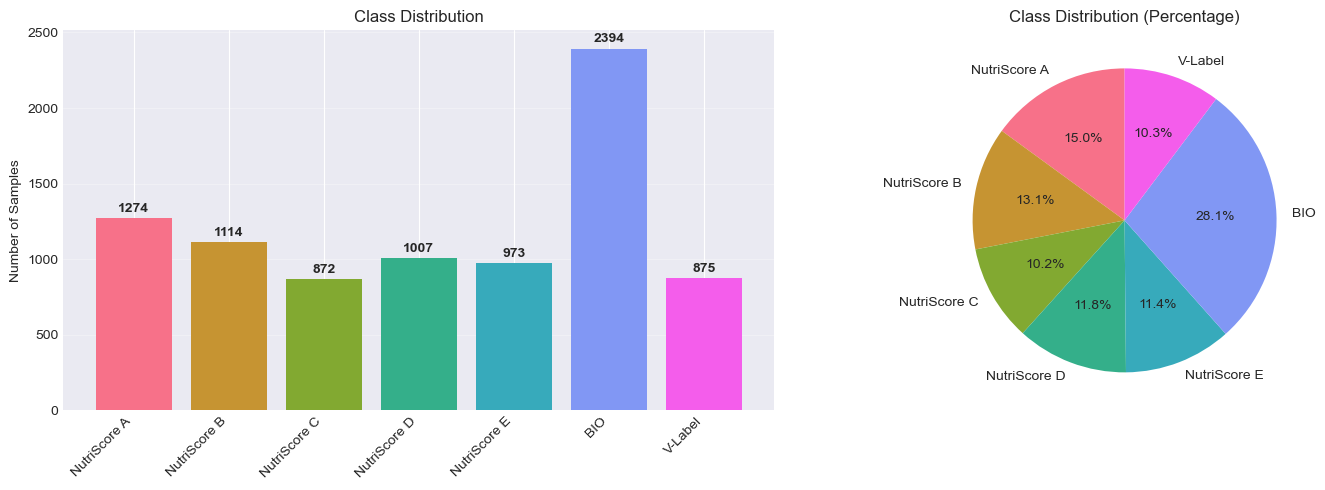

In [5]:

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
axes[0].bar(range(len(class_counts)), class_counts.values, color=sns.color_palette("husl", len(class_counts)))
axes[0].set_xticks(range(len(class_counts)))
axes[0].set_xticklabels([class_names[i] for i in class_counts.index], rotation=45, ha='right')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Class Distribution')
axes[0].grid(axis='y', alpha=0.3)

# Add counts on bars
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=[class_names[i] for i in class_counts.index], 
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl", len(class_counts)))
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.savefig(YOLO_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Class distribution plot saved to: {YOLO_DIR / 'class_distribution.png'}")
plt.show()



BOUNDING BOX ANALYSIS

Bounding box statistics:
  Width  - Mean: 0.1703, Std: 0.0749
  Height - Mean: 0.1058, Std: 0.0478
  X      - Mean: 0.4701, Std: 0.2788
  Y      - Mean: 0.7299, Std: 0.2051
✓ Bounding box analysis plot saved to: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data\bbox_analysis.png


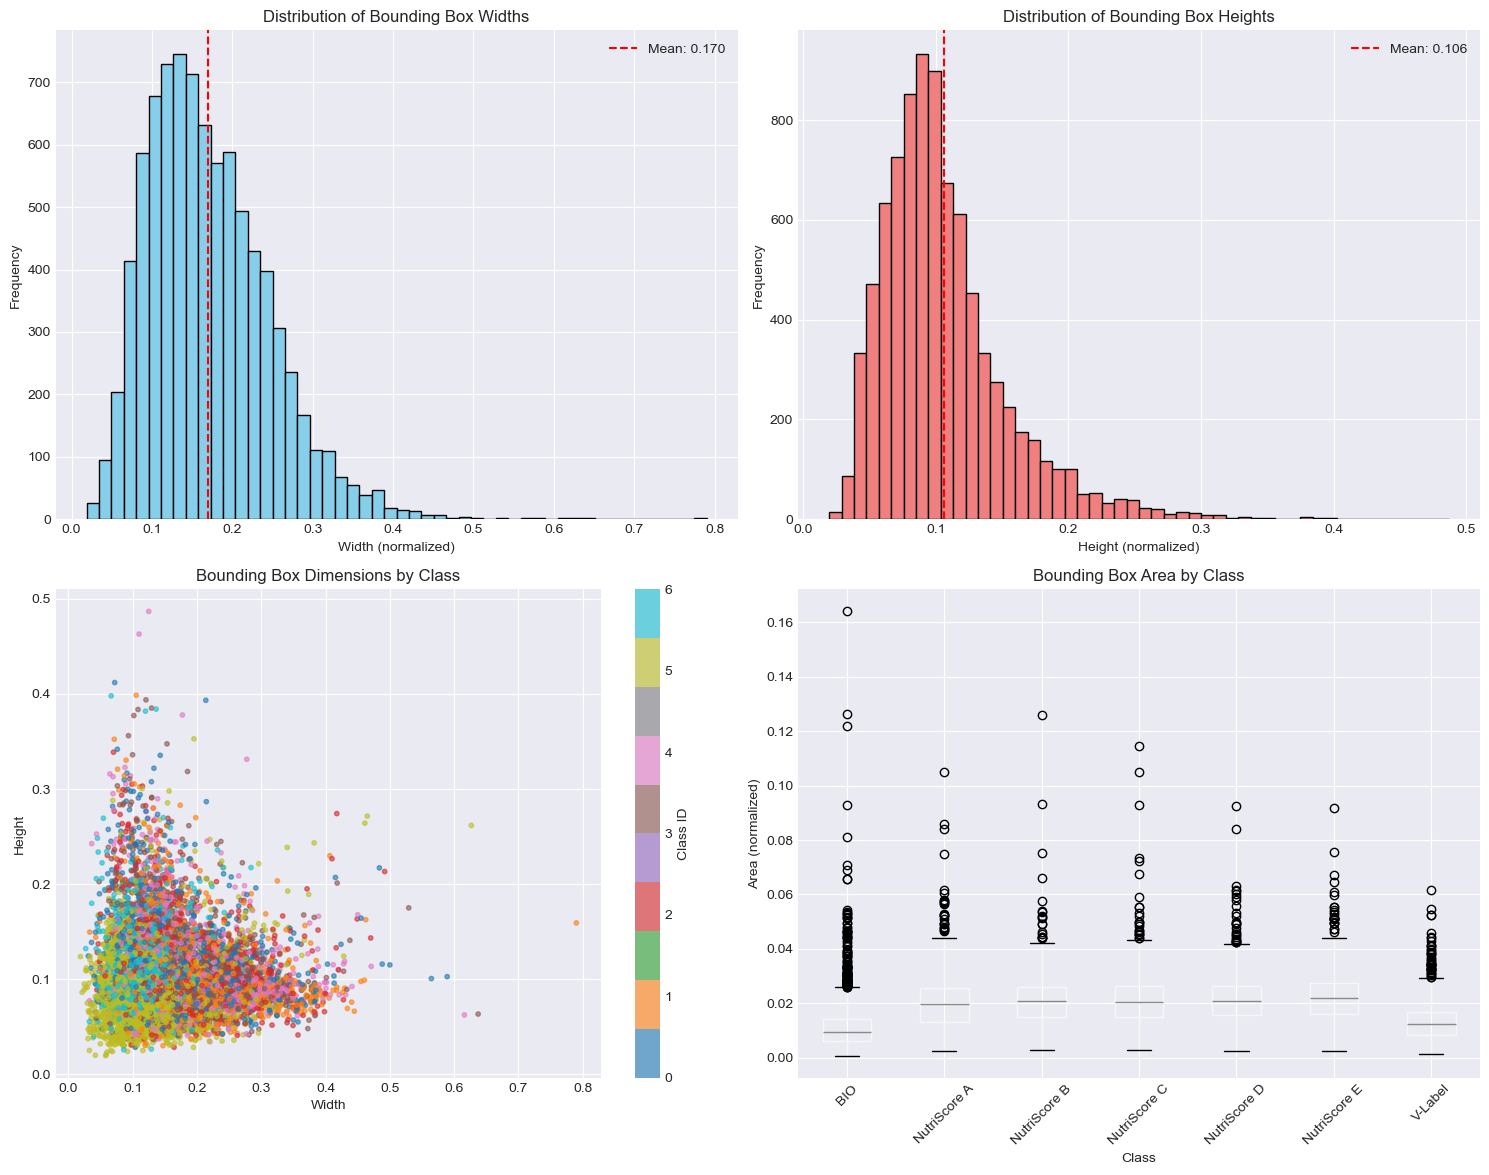

In [6]:

# ============================================================================
# 4. BOUNDING BOX ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("BOUNDING BOX ANALYSIS")
print("=" * 80)

print("\nBounding box statistics:")
print(f"  Width  - Mean: {df['Width'].mean():.4f}, Std: {df['Width'].std():.4f}")
print(f"  Height - Mean: {df['Height'].mean():.4f}, Std: {df['Height'].std():.4f}")
print(f"  X      - Mean: {df['X'].mean():.4f}, Std: {df['X'].std():.4f}")
print(f"  Y      - Mean: {df['Y'].mean():.4f}, Std: {df['Y'].std():.4f}")

# Visualize bounding box distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(df['Width'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Width (normalized)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Bounding Box Widths')
axes[0, 0].axvline(df['Width'].mean(), color='red', linestyle='--', label=f'Mean: {df["Width"].mean():.3f}')
axes[0, 0].legend()

axes[0, 1].hist(df['Height'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Height (normalized)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Bounding Box Heights')
axes[0, 1].axvline(df['Height'].mean(), color='red', linestyle='--', label=f'Mean: {df["Height"].mean():.3f}')
axes[0, 1].legend()

# Scatter plot of width vs height
scatter = axes[1, 0].scatter(df['Width'], df['Height'], c=df['Class ID'], 
                             cmap='tab10', alpha=0.6, s=10)
axes[1, 0].set_xlabel('Width')
axes[1, 0].set_ylabel('Height')
axes[1, 0].set_title('Bounding Box Dimensions by Class')
plt.colorbar(scatter, ax=axes[1, 0], label='Class ID')

# Box plot by class
df_plot = df.copy()
df_plot['Area'] = df_plot['Width'] * df_plot['Height']
df_plot.boxplot(column='Area', by='Class Name', ax=axes[1, 1], rot=45)
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Area (normalized)')
axes[1, 1].set_title('Bounding Box Area by Class')
plt.suptitle('')

plt.tight_layout()
plt.savefig(YOLO_DIR / 'bbox_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Bounding box analysis plot saved to: {YOLO_DIR / 'bbox_analysis.png'}")
plt.show()

In [7]:
# ============================================================================
# 5. IMAGE ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("IMAGE ANALYSIS")
print("=" * 80)

# Sample some images to analyze dimensions
image_files = list(IMAGES_DIR.glob("*.jpg"))[:100]
image_sizes = []

for img_path in image_files:
    try:
        img = Image.open(img_path)
        image_sizes.append(img.size)
    except:
        pass

if image_sizes:
    widths, heights = zip(*image_sizes)
    print(f"\nImage dimensions (from {len(image_sizes)} samples):")
    print(f"  Width  - Mean: {np.mean(widths):.0f}px, Min: {np.min(widths)}px, Max: {np.max(widths)}px")
    print(f"  Height - Mean: {np.mean(heights):.0f}px, Min: {np.min(heights)}px, Max: {np.max(heights)}px")


IMAGE ANALYSIS

Image dimensions (from 100 samples):
  Width  - Mean: 1526px, Min: 155px, Max: 4032px
  Height - Mean: 2049px, Min: 250px, Max: 4032px



LABELS PER IMAGE ANALYSIS

Labels per image statistics:
  Mean: 1.17
  Median: 1
  Min: 1
  Max: 8
✓ Labels per image plot saved to: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data\labels_per_image.png


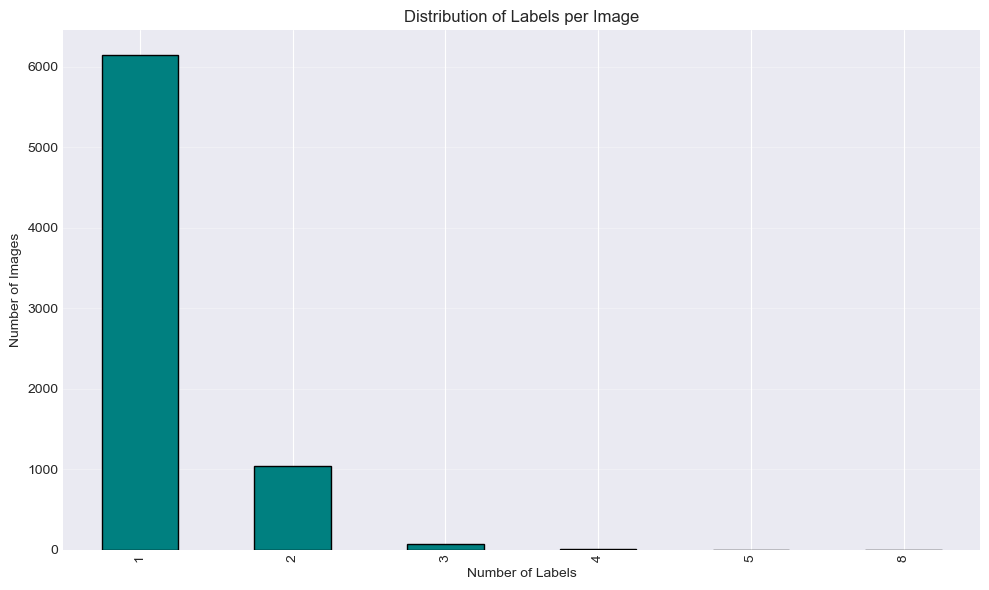

In [8]:
# ============================================================================
# 6. LABELS PER IMAGE ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("LABELS PER IMAGE ANALYSIS")
print("=" * 80)

labels_per_image = df.groupby('File Name').size()
print(f"\nLabels per image statistics:")
print(f"  Mean: {labels_per_image.mean():.2f}")
print(f"  Median: {labels_per_image.median():.0f}")
print(f"  Min: {labels_per_image.min()}")
print(f"  Max: {labels_per_image.max()}")

fig, ax = plt.subplots(figsize=(10, 6))
labels_per_image.value_counts().sort_index().plot(kind='bar', ax=ax, color='teal', edgecolor='black')
ax.set_xlabel('Number of Labels')
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Labels per Image')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(YOLO_DIR / 'labels_per_image.png', dpi=300, bbox_inches='tight')
print(f"✓ Labels per image plot saved to: {YOLO_DIR / 'labels_per_image.png'}")
plt.show()

In [14]:
# ============================================================================
# 7. PREPARE DATA FOR YOLOV5 TRAINING
# ============================================================================
print("\n" + "=" * 80)
print("PREPARING DATA FOR YOLOV5")
print("=" * 80)

# ============================================================================
# FIX: Replace .txt with .jpg in File Name column
# ============================================================================
print("\nFixing filename extensions...")

# Replace .txt with .jpg
df['File Name'] = df['File Name'].str.replace('.txt', '.jpg', regex=False)

print(f"Sample corrected filenames: {df['File Name'].unique()[:5]}")

# Get unique image filenames
unique_images = df['File Name'].unique()
np.random.seed(42)
np.random.shuffle(unique_images)

print(f"Total unique images: {len(unique_images)}")
print(f"First 5: {list(unique_images[:5])}")

# Test if files exist now
test_img = unique_images[0]
test_path = IMAGES_DIR / test_img
print(f"\nTest: {test_path.exists()} - {test_path}")

# Split: 70% train, 15% val, 15% test
train_size = int(0.70 * len(unique_images))
val_size = int(0.15 * len(unique_images))

train_images = unique_images[:train_size]
val_images = unique_images[train_size:train_size + val_size]
test_images = unique_images[train_size + val_size:]

print(f"\nDataset split:")
print(f"  Training:   {len(train_images)} images ({len(train_images)/len(unique_images)*100:.1f}%)")
print(f"  Validation: {len(val_images)} images ({len(val_images)/len(unique_images)*100:.1f}%)")
print(f"  Testing:    {len(test_images)} images ({len(test_images)/len(unique_images)*100:.1f}%)")

# Function to copy files to YOLOv5 structure
def copy_files_to_split(image_list, split_name):
    """Copy images and labels to train/val/test directories"""
    copied_images = 0
    copied_labels = 0
    
    for img_name in image_list:
        # Copy image
        src_img = IMAGES_DIR / img_name
        dst_img = YOLO_DIR / split_name / 'images' / img_name
        
        if src_img.exists():
            shutil.copy2(src_img, dst_img)
            copied_images += 1
            
            # Create label file
            label_name = img_name.replace('.jpg', '.txt')
            dst_label = YOLO_DIR / split_name / 'labels' / label_name
            
            # Get all annotations for this image
            img_annotations = df[df['File Name'] == img_name]
            
            with open(dst_label, 'w') as f:
                for _, row in img_annotations.iterrows():
                    # YOLOv5 format: class_id x_center y_center width height
                    f.write(f"{int(row['Class ID'])} {row['X']:.6f} {row['Y']:.6f} {row['Width']:.6f} {row['Height']:.6f}\n")
            
            copied_labels += 1
    
    return copied_images, copied_labels

# Copy files
print("\nCopying files to YOLOv5 directory structure...")
train_img, train_lbl = copy_files_to_split(train_images, 'train')
val_img, val_lbl = copy_files_to_split(val_images, 'val')
test_img, test_lbl = copy_files_to_split(test_images, 'test')

print(f"  Train: {train_img} images, {train_lbl} label files")
print(f"  Val:   {val_img} images, {val_lbl} label files")
print(f"  Test:  {test_img} images, {test_lbl} label files")

print("\n✓ Data preparation for YOLOv5 completed!")


PREPARING DATA FOR YOLOV5

Fixing filename extensions...
Sample corrected filenames: ['nutriScoreD (657).jpg' 'nutriScoreE (535).jpg' '3256226080853.jpg'
 'nutriScoreD (207).jpg' 'nutriScoreB (98).jpg']
Total unique images: 7271
First 5: ['26024493.jpg', '140vegan.jpg', '3560071081362.jpg', 'nutriScoreD (761).jpg', 'nutriScoreA (504).jpg']

Test: True - C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\images\26024493.jpg

Dataset split:
  Training:   5089 images (70.0%)
  Validation: 1090 images (15.0%)
  Testing:    1092 images (15.0%)

Copying files to YOLOv5 directory structure...
  Train: 5089 images, 5089 label files
  Val:   1090 images, 1090 label files
  Test:  1092 images, 1092 label files

✓ Data preparation for YOLOv5 completed!


In [10]:
# ============================================================================
# 8. CREATE YOLOV5 YAML CONFIG
# ============================================================================
print("\n" + "=" * 80)
print("CREATING YOLOV5 CONFIG FILE")
print("=" * 80)

yaml_content = f"""# NutriGreen Dataset Configuration for YOLOv5

# Paths
path: {str(YOLO_DIR.resolve())}  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images  # val images (relative to 'path')
test: test/images  # test images (relative to 'path')

# Classes
nc: 7  # number of classes
names: ['NutriScore A', 'NutriScore B', 'NutriScore C', 'NutriScore D', 'NutriScore E', 'BIO', 'V-Label']
"""

config_path = YOLO_DIR / 'nutrigreen.yaml'
with open(config_path, 'w') as f:
    f.write(yaml_content)

print(f"✓ YOLOv5 config file created at: {config_path}")
print(f"\nConfig contents:")
print(yaml_content)


CREATING YOLOV5 CONFIG FILE
✓ YOLOv5 config file created at: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data\nutrigreen.yaml

Config contents:
# NutriGreen Dataset Configuration for YOLOv5

# Paths
path: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images  # val images (relative to 'path')
test: test/images  # test images (relative to 'path')

# Classes
nc: 7  # number of classes
names: ['NutriScore A', 'NutriScore B', 'NutriScore C', 'NutriScore D', 'NutriScore E', 'BIO', 'V-Label']



In [11]:
# ============================================================================
# 9. SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("EDA SUMMARY")
print("=" * 80)

summary = f"""
Dataset: NutriGreen Food Labels
Total Images: {len(unique_images)}
Total Annotations: {len(df)}
Classes: {len(class_names)}

Split Distribution:
  • Training:   {len(train_images)} images ({len(train_images)/len(unique_images)*100:.1f}%)
  • Validation: {len(val_images)} images ({len(val_images)/len(unique_images)*100:.1f}%)
  • Testing:    {len(test_images)} images ({len(test_images)/len(unique_images)*100:.1f}%)

Class Balance:
  Most common: {class_names[class_counts.idxmax()]} ({class_counts.max()} samples)
  Least common: {class_names[class_counts.idxmin()]} ({class_counts.min()} samples)

All files prepared for YOLOv5 training at:
  {YOLO_DIR}

Next Steps:
  1. Run the training notebook: nutrigreen_training.ipynb
  2. Evaluate with: nutrigreen_evaluation.ipynb
  3. Deploy with: nutrigreen_app.py
"""

print(summary)

# Save summary
with open(YOLO_DIR / 'eda_summary.txt', 'w') as f:
    f.write(summary)

print(f"✓ Summary saved to: {YOLO_DIR / 'eda_summary.txt'}")
print("\n" + "=" * 80)
print("EDA COMPLETE!")
print("=" * 80)


EDA SUMMARY

Dataset: NutriGreen Food Labels
Total Images: 7271
Total Annotations: 8509
Classes: 7

Split Distribution:
  • Training:   5089 images (70.0%)
  • Validation: 1090 images (15.0%)
  • Testing:    1092 images (15.0%)

Class Balance:
  Most common: BIO (2394 samples)
  Least common: NutriScore C (872 samples)

All files prepared for YOLOv5 training at:
  C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data

Next Steps:
  1. Run the training notebook: nutrigreen_training.ipynb
  2. Evaluate with: nutrigreen_evaluation.ipynb
  3. Deploy with: nutrigreen_app.py

✓ Summary saved to: C:\Users\lokes\Desktop\ironhack\final_project\dataset\dataset\yolov5_data\eda_summary.txt

EDA COMPLETE!
